In [70]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns

data = './data/water.csv'
water = pd.read_csv(data, index_col=0)
  
water.head()

,lat_deg,lon_deg,report_date,status_id,water_source,water_tech,facility_type,country_name,install_year,installer,pay,status
row_id,,,,,,,,,,,,
3957,8.073136,38.617037,04/06/2017,y,NaN,NaN,NaN,Ethiopia,NaN,Private-CRS,NaN,NaN
33512,7.373784,40.503824,08/04/2020,y,Protected Spring,NaN,Improved,Ethiopia,2019.0,WaterAid,NaN,NaN
35125,0.773458,34.929509,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
37760,0.780576,34.963640,03/18/2015,y,Borehole,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
38118,0.779266,34.971120,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN


In [71]:
water.rename(
  {'lat_deg':'lat',
  'lon_deg':'lon',
  'country_name':'country'}, axis=1, inplace=True)

In [72]:
uniques = {col:list(water[col].unique()) for col in water.columns[4:]}

print(uniques['water_tech']) # Includes both method and development company after '-'
print(uniques['country']) # Includes nan values and non-African countries: Peru, Dominican Republic, Timor-Leste

[nan, 'Hand Pump - India Mark', 'Mechanized Pump', 'Tapstand', 'Hand Pump', 'Kiosk', 'Hand Pump - Vergnet', 'Hand Pump - Nira', 'Hand Pump - Afridev', 'Rope and Bucket', 'Mechanized Pump - Solar', 'Hand Pump - Canzee', 'Hydram', 'Hand Pump - Kardia', 'Hand Pump - Consallen', 'Hand Pump - Inkar', 'Hand Pump - SWN 80', 'Hand Pump - Indus', 'Hand Pump - PB Mark II', 'Mechanized Pump - Diesel']
['Ethiopia', 'Kenya', 'Central African Republic', 'Uganda', 'Niger', 'Mozambique', 'Liberia', 'Peru', 'Swaziland', 'Sierra Leone', 'Zambia', 'Nigeria', 'Ghana', 'Burkina Faso', 'Zimbabwe', 'Madagascar', 'Tanzania', 'South Sudan', 'Mali', 'Rwanda', 'South Africa', nan, 'Dominican Republic', 'Burundi', 'Gambia', 'Congo - Kinshasa', 'Angola', 'Algeria', 'Namibia', 'Sudan', 'Congo - Brazzaville', 'Chad', 'Mauritania', 'Timor-Leste', 'Egypt']


In [73]:
water['report_date'] = pd.to_datetime(water['report_date'])
water[['water_tech','brand']] = water['water_tech'].str.split('-',expand=True)
water = water[~water['country'].isin(['Peru', 'Dominican Republic', 'Timor-Leste'])]
water = water[~water['country'].isna()]

<AxesSubplot: xlabel='install_year', ylabel='Count'>

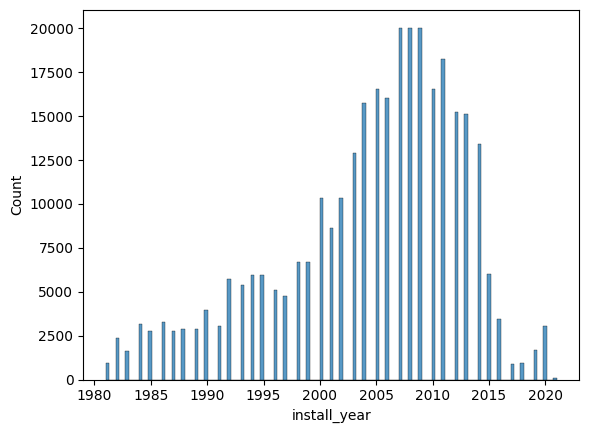

In [74]:
# sns.histplot(water['install_year']) # Includes years after 2021
water['install_year'] = np.where(water['install_year'] > 2021, np.nan, water['install_year'])

df = water[water['install_year'] > 1980]
sns.histplot(df['install_year'])

#### Creating a Map


In [79]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

def get_points(df):
  return [Point(xy) for xy in zip(df['lon'], df['lat'])]

gdf = gpd.GeoDataFrame(water, geometry=get_points(water))

world = gpd.read_file(
  gpd.datasets.get_path('naturalearth_lowres')
)
africa = world.query('continent == "Africa"')

<AxesSubplot: >

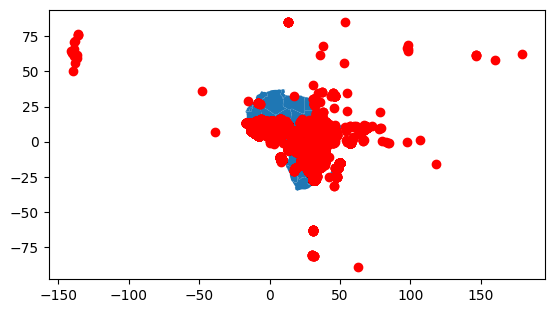

In [80]:
gdf.plot(ax=africa.plot(), marker = 'o', color='red')

A lot of erroneous points lying outside the actual continent. 

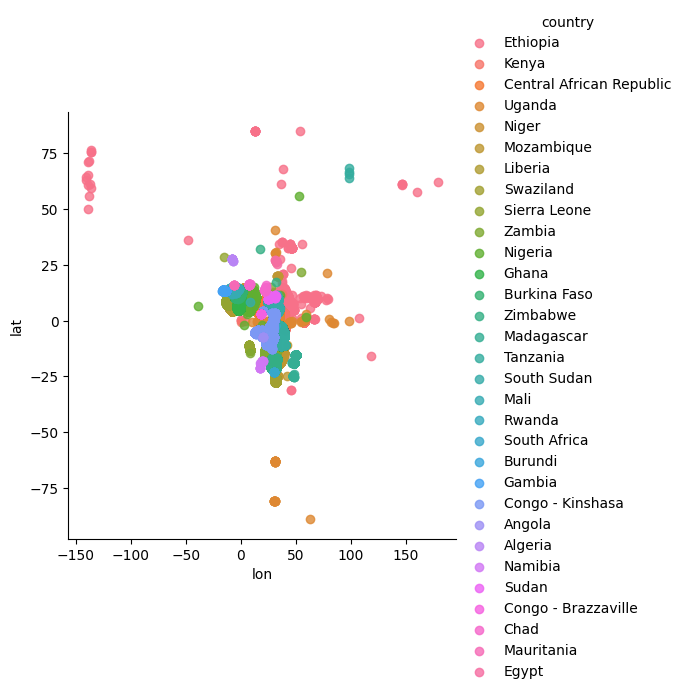

In [83]:
sns.lmplot(data=water, x='lon', y='lat', fit_reg=False, hue='country')

Hard to tell which countries the outlier points belong to based on subtle differences in hues. Plotting the country name next to each point for more than 400k points is also not going to make things clear! 

We can, however, calculate the center of each country as the mean of all the coordinates located within that country, and then exclude points belonging to any country which lie outside a certain distance of its respective center. 

In [120]:
df = water[['country', 'lat', 'lon']].groupby('country').mean()
df.reset_index(inplace=True)
df

,country,lat,lon
0,Algeria,27.512962,-7.773892
1,Angola,-7.402311,20.055199
2,Burkina Faso,11.824792,-2.837905
3,Burundi,-3.155000,29.835000
4,Central African Republic,5.148619,17.160594
5,Chad,15.498707,12.942182
6,Congo - Brazzaville,3.092094,18.538947
7,Congo - Kinshasa,-2.988338,26.201318
8,Egypt,26.601359,31.670891
9,Ethiopia,10.421060,38.562526


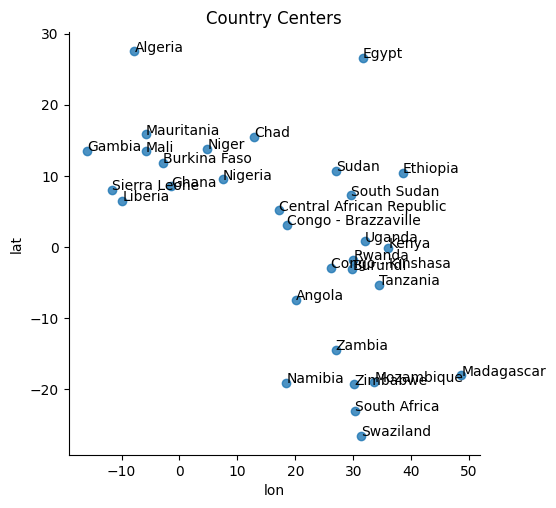

In [121]:
import matplotlib.pyplot as plt

ax = sns.lmplot(x='lon', 
           y='lat', 
           data=df, 
           fit_reg=False)  

plt.title('Country Centers')
# Set x-axis label
plt.xlabel('lon')
# Set y-axis label
plt.ylabel('lat')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df.lon, df.lat, df.country, plt.gca())

In [122]:
df = gpd.GeoDataFrame(df['country'], geometry=get_points(df))

,country,geometry
0,Algeria,POINT (-7.77389 27.51296)
1,Angola,POINT (20.05520 -7.40231)
2,Burkina Faso,POINT (-2.83791 11.82479)
3,Burundi,POINT (29.83500 -3.15500)
4,Central African Republic,POINT (17.16059 5.14862)
5,Chad,POINT (12.94218 15.49871)
6,Congo - Brazzaville,POINT (18.53895 3.09209)
7,Congo - Kinshasa,POINT (26.20132 -2.98834)
8,Egypt,POINT (31.67089 26.60136)
9,Ethiopia,POINT (38.56253 10.42106)
